In [3]:
import librosa
import torchaudio
import torch
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\jiyun\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\jiyun\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


***
### Specgram of Notes

In [2]:
note_paths = {
    "A": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\A_1.mp3",
    "B": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\B_3.mp3",
    "C": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\C_1.mp3",
    "D": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\D_4.mp3",
    "E": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\E_1.mp3",
    "G": r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\notes\G_10.mp3"
}

In [4]:
def spectrogram(waveform, sr, chunk_size_s=None, overlap=0):
    if chunk_size_s == None:
        return torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256)(torch.Tensor(waveform).reshape(1,-1))

    chunk_size = int(chunk_size_s * sr)

    def chunk_waveform(waveform, chunk_size, overlap):
        idx = 0
        # overlap_chunk = 0
        overlap_chunk = int(overlap * chunk_size)
        while idx + chunk_size - overlap_chunk <= len(waveform):
            yield waveform[idx:idx + chunk_size - overlap_chunk]
            idx += chunk_size - overlap_chunk

    chunks = torch.FloatTensor(list(chunk_waveform(waveform, chunk_size, overlap)))
#     chunk = chunks[0]

    specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256)(chunks)
#     specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256)(chunk.reshape(1,-1))
    return specgram

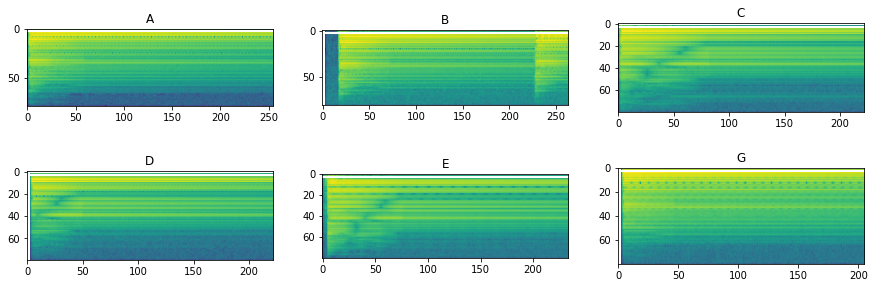

In [11]:
chunk_size_s = None
overlap = 0

fig = plt.figure(figsize=(15,5))
for idx, note in enumerate(note_paths):
    waveform, sr = librosa.load(note_paths[note])
    specgram = spectrogram(waveform, sr, chunk_size_s=chunk_size_s, overlap=overlap)
    plt.subplot(2, 3, idx+1)
    plt.title(note)
    plt.imshow(specgram.log2()[0,:,:].detach().numpy())

# plt.show()
plt.savefig("./outputs/twinkle_notes.png")

C:\Users\jiyun\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
C:\Users\jiyun\anaconda3\lib\site-packages\torchaudio\functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


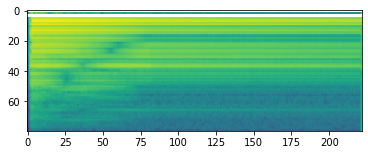

In [7]:
waveform, sr = librosa.load(note_paths["C"])
specgram = spectrogram(waveform, sr, chunk_size_s=chunk_size_s, overlap=overlap)
plt.imshow(specgram.log2()[0,:,:].detach().numpy())
plt.savefig("./outputs/C_spec.png")

***
### Smaller chunks still recognized?

In [5]:
import sys
sys.path.insert(1, r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch")
from classifier_model import Net

In [6]:
state_path = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch\model\classifier_bs10_lr0.002_epoch100.pt"
net = Net()
net.load_state_dict(torch.load(state_path))
net.eval()

Net(
  (conv1): Conv1d(80, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2080, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [40]:
quarter_sec_spec.repeat_interleave(7, dim=-1).shape

torch.Size([1, 80, 308])

In [73]:
waveform, sr = librosa.load(note_paths["D"])
quarter_sec = waveform[:int(0.25*sr)]
quarter_sec_spec = spectrogram(quarter_sec, sr, chunk_size_s=None, overlap=0)
quarter_sec_data = torch.zeros(1, 80, 270)
quarter_sec_data[:,:,:quarter_sec_spec.shape[-1]] = quarter_sec_spec #PADDING WITH ZEROS
# quarter_sec_data = quarter_sec_spec.repeat_interleave(7, dim=-1)[:,:,:270] #STRETCHING
output = net(quarter_sec_data)

In [74]:
pred = output.argmax(axis=1)
pred

tensor([2])

In [48]:
len(waveform)

27384

In [52]:
0.25*sr*4

22050.0

In [58]:
chunk_data.shape

torch.Size([1, 80, 270])

In [75]:
chunk_specs = spectrogram(waveform, sr, chunk_size_s=0.25, overlap=0)
chunk_data = torch.zeros(chunk_specs.shape[0], 80, 270)
chunk_data[:,:,:chunk_specs.shape[-1]] = chunk_specs #PADDING WITH ZEROS
outputs = net(chunk_data)
labels = outputs.argmax(axis=1)

In [84]:
chunk_data.shape

torch.Size([5, 80, 270])

In [82]:
spec = spectrogram(waveform, sr, chunk_size_s=None, overlap=0)
spec_data = torch.zeros(1, 80, 270)
spec_data[:, :, :spec.shape[-1]] = spec  # PADDING WITH ZEROS
output = net(spec_data)
label = output.argmax(axis=1)

In [83]:
label

tensor([2])

***
### Analysis of classification

In [5]:
pred_notes = pd.read_csv(r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch\predicted_notes.csv", index_col=0)
target_notes = pd.read_csv(r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\wavenet_pytorch\target_notes.csv", index_col=0)
pred_notes.index.name = "Epochs"
target_notes.index.name = "Epochs"

In [6]:
# map notes from integer to value for easier reading
note_dict = {
    0:"A", 1:"C", 2:"D", 3:"E", 4:"F", 5:"G"
}
pred_notes.replace(note_dict, inplace=True)
target_notes.replace(note_dict, inplace=True)

In [7]:
pred_notes

,0,1,2,3,4,5,6,7,8,9
Epochs,,,,,,,,,,
0,F,F,F,F,F,F,F,F,F,F
1,F,F,F,F,F,F,F,F,F,F
2,F,F,F,F,F,F,F,F,F,F
3,F,F,F,F,F,F,F,F,F,F
4,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...
95,F,F,C,E,C,G,E,E,G,D
96,D,E,A,F,A,F,G,F,D,C
97,D,F,G,E,F,C,A,E,F,G


In [8]:
target_notes

,0,1,2,3,4,5,6,7,8,9
Epochs,,,,,,,,,,
0,C,A,G,G,A,G,C,F,G,G
1,E,E,G,G,E,D,F,F,D,G
2,F,E,G,F,F,G,G,E,D,E
3,G,F,A,A,G,D,C,F,F,F
4,C,C,E,C,F,G,F,F,C,G
...,...,...,...,...,...,...,...,...,...,...
95,F,F,C,E,C,G,E,E,G,D
96,D,E,A,F,A,F,G,F,D,C
97,D,F,G,E,F,C,A,E,F,G


In [9]:
len(pred_notes)

100

In [10]:
# take a look at only last half of epochs
pred_notes = pred_notes.iloc[len(pred_notes)//2:]
target_notes = target_notes.iloc[len(target_notes)//2:]

In [11]:
notes = ["A","C","D","E","F","G"]
note_pred_stats = pd.DataFrame(columns=["total", "correct"], index=notes)
for note in notes:
    total_num_note = (target_notes==note).sum().sum()
    correct_pred = pred_notes[pred_notes==note].eq(target_notes).sum().sum()
    note_pred_stats.loc[note] = [total_num_note, correct_pred]

In [12]:
note_pred_stats["correct %"] = note_pred_stats["correct"]/note_pred_stats["total"] * 100

In [13]:
note_pred_stats

,total,correct,correct %
A,49,49,100
C,74,74,100
D,66,64,96.9697
E,83,83,100
F,102,102,100
G,126,126,100


<AxesSubplot:title={'center':'Total number of each note'}, ylabel='total'>

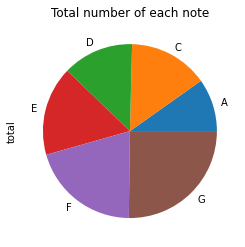

In [14]:
note_pred_stats["total"].plot.pie(title="Total number of each note")